<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg" 
     width="30%" 
     align=right
     alt="Dask logo">

DataFrames and Timeseries
------------------

This notebook uses [Dask dataframe](http://dask.pydata.org/en/latest/dataframe.html), a parallel version of [Pandas](http://pandas.pydata.org) on a cluster.  It shows off both the Dask dataframe API and how to operate with the [distributed cluster](http://distributed.readthedocs.io/en/latest/api.html).

In [31]:
from dask.distributed import Client, progress
# c = Client()  # for local cluster
# c = Client(cluster)   # KubeCluster() class instantiation

# address parameter value is scheduler address from dask lab extension cluster creation
c = Client(address='127.0.0.1:41477')
c

/opt/conda/lib/python3.8/site-packages/distributed/client.py:1133: VersionMismatchWarning: Mismatched versions found

+-------------+---------------+---------------+---------------+
| Package     | client        | scheduler     | workers       |
+-------------+---------------+---------------+---------------+
| blosc       | 1.10.1        | 1.10.1        | 1.9.2         |
| dask        | 2021.01.0     | 2021.01.0     | 2021.02.0     |
| distributed | 2021.01.0     | 2021.01.0     | 2021.02.0     |
| lz4         | 3.1.2         | 3.1.2         | 3.1.1         |
| msgpack     | 1.0.2         | 1.0.2         | 1.0.0         |
| python      | 3.8.6.final.0 | 3.8.6.final.0 | 3.8.0.final.0 |
| tornado     | 6.0.4         | 6.0.4         | 6.1           |
+-------------+---------------+---------------+---------------+
Notes: 
-  msgpack: Variation is ok, as long as everything is above 0.6
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Client Scheduler: tcp://127.0.0.1:41477 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 3 Cores: 6 Memory: 6.00 GB


In [32]:
import dask.dataframe as dd

df = dd.demo.make_timeseries('2010', '2016',
                             {'value': float, 'name': str, 'id': int},
                             freq='10s', partition_freq='7d', seed=1)

df = df[df.value > 0][['id', 'value', 'name']]

df.head()

,id,value,name
timestamp,,,
2010-01-01 00:00:10,955,0.593030,Frank
2010-01-01 00:00:20,991,0.331898,Jerry
2010-01-01 00:00:50,984,0.388256,Xavier
2010-01-01 00:01:00,963,0.197801,Dan
2010-01-01 00:01:20,1019,0.018332,Yvonne


In [33]:
df = df.persist()
progress(df)

VBox()

In [34]:
%time len(df)

CPU times: user 212 ms, sys: 51.5 ms, total: 263 ms
Wall time: 4.66 s


9464412

In [35]:
%time df.groupby(df.id).value.mean().nlargest(10).compute()

CPU times: user 471 ms, sys: 92.3 ms, total: 563 ms
Wall time: 13.7 s


id
1156    0.908368
852     0.899368
841     0.856013
1173    0.825994
1161    0.822107
1165    0.803438
1152    0.797171
1158    0.732588
854     0.724765
1144    0.716518
Name: value, dtype: float64

### Quickly get data for a particular time or date range

In [36]:
%time df.loc['2015-12-25'].head()

CPU times: user 37.4 ms, sys: 5.64 ms, total: 43.1 ms
Wall time: 78.9 ms


,id,value,name
timestamp,,,
2015-12-25 00:00:00,994,0.919311,Yvonne
2015-12-25 00:00:10,992,0.035872,Zelda
2015-12-25 00:00:20,977,0.772903,Sarah
2015-12-25 00:00:30,1010,0.449239,Laura
2015-12-25 00:00:50,1013,0.380744,Zelda


### Aggregations

In [37]:
df.value.std().compute()

0.288673098727659

### Filtering

In [38]:
df2 = df[df.name == 'Hannah']
df2.head()

,id,value,name
timestamp,,,
2010-01-01 00:09:40,1014,0.689966,Hannah
2010-01-01 00:23:30,1025,0.445631,Hannah
2010-01-01 00:31:50,1010,0.554102,Hannah
2010-01-01 00:39:40,1026,0.338665,Hannah
2010-01-01 00:49:10,1023,0.632757,Hannah


### Groupby operations

In [39]:
df.groupby(df.name).value.min().compute()

name
Alice       2.129143e-06
Bob         6.895881e-07
Charlie     1.416773e-07
Dan         5.003646e-07
Edith       5.564204e-06
Frank       4.554380e-07
George      7.179896e-06
Hannah      1.236376e-06
Ingrid      2.999408e-06
Jerry       1.854690e-06
Kevin       4.760845e-06
Laura       6.534131e-06
Michael     1.746191e-06
Norbert     3.147327e-06
Oliver      5.752716e-06
Patricia    2.127540e-06
Quinn       3.284675e-06
Ray         4.683078e-06
Sarah       6.672974e-07
Tim         2.267828e-06
Ursula      4.982952e-06
Victor      3.257956e-06
Wendy       5.834423e-08
Xavier      4.025504e-06
Yvonne      1.931880e-06
Zelda       2.388407e-06
Name: value, dtype: float64

### Resample by day

In [40]:
df.value.resample('1d').mean().head()

timestamp
2010-01-01    0.493917
2010-01-02    0.495344
2010-01-03    0.504383
2010-01-04    0.498244
2010-01-05    0.504439
Freq: D, Name: value, dtype: float64

### Rolling aggregations

In [41]:
df.value.rolling(100).mean().tail()

timestamp
2015-12-31 23:58:30    0.479710
2015-12-31 23:58:40    0.475818
2015-12-31 23:59:00    0.478459
2015-12-31 23:59:40    0.476589
2015-12-31 23:59:50    0.478680
Name: value, dtype: float64

### Understanding algorithms with the `visualize` method

In this example we look at a smaller dataset and see how Dask.dataframe would resample data that is organized by month to data that is organized by week.  This is a bit messy because weeks and months don't line up perfectly.  Fortunately Dask's task scheduler are built for this sort of messy situation.

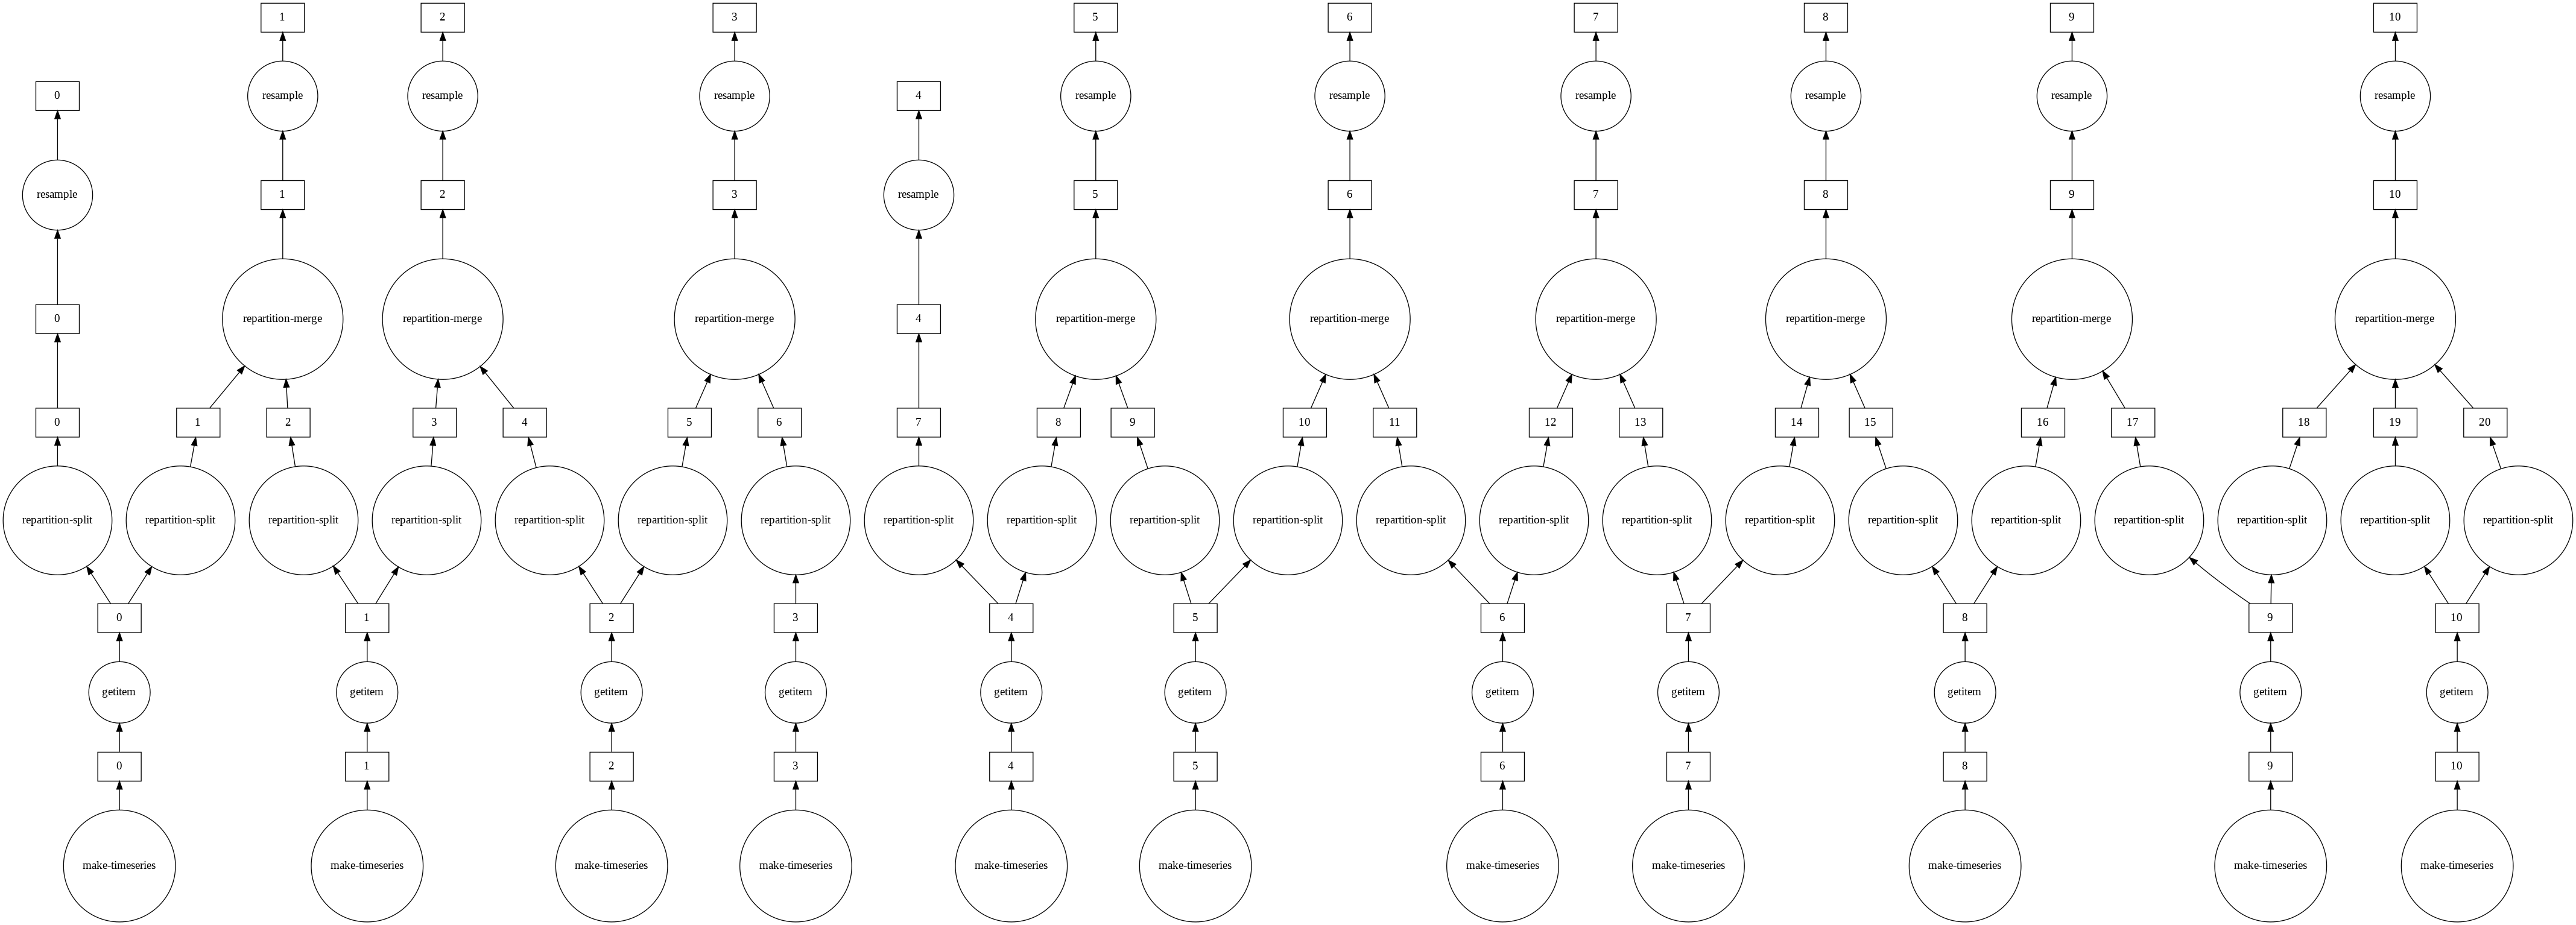

In [42]:
df_small = dd.demo.make_timeseries('2010-01-01', '2010-12-31',
                                   {'value': float, 'name': str, 'id': int},
                                   freq='10s', partition_freq='1M', seed=1)
df_small.value.resample('1w').mean().visualize()

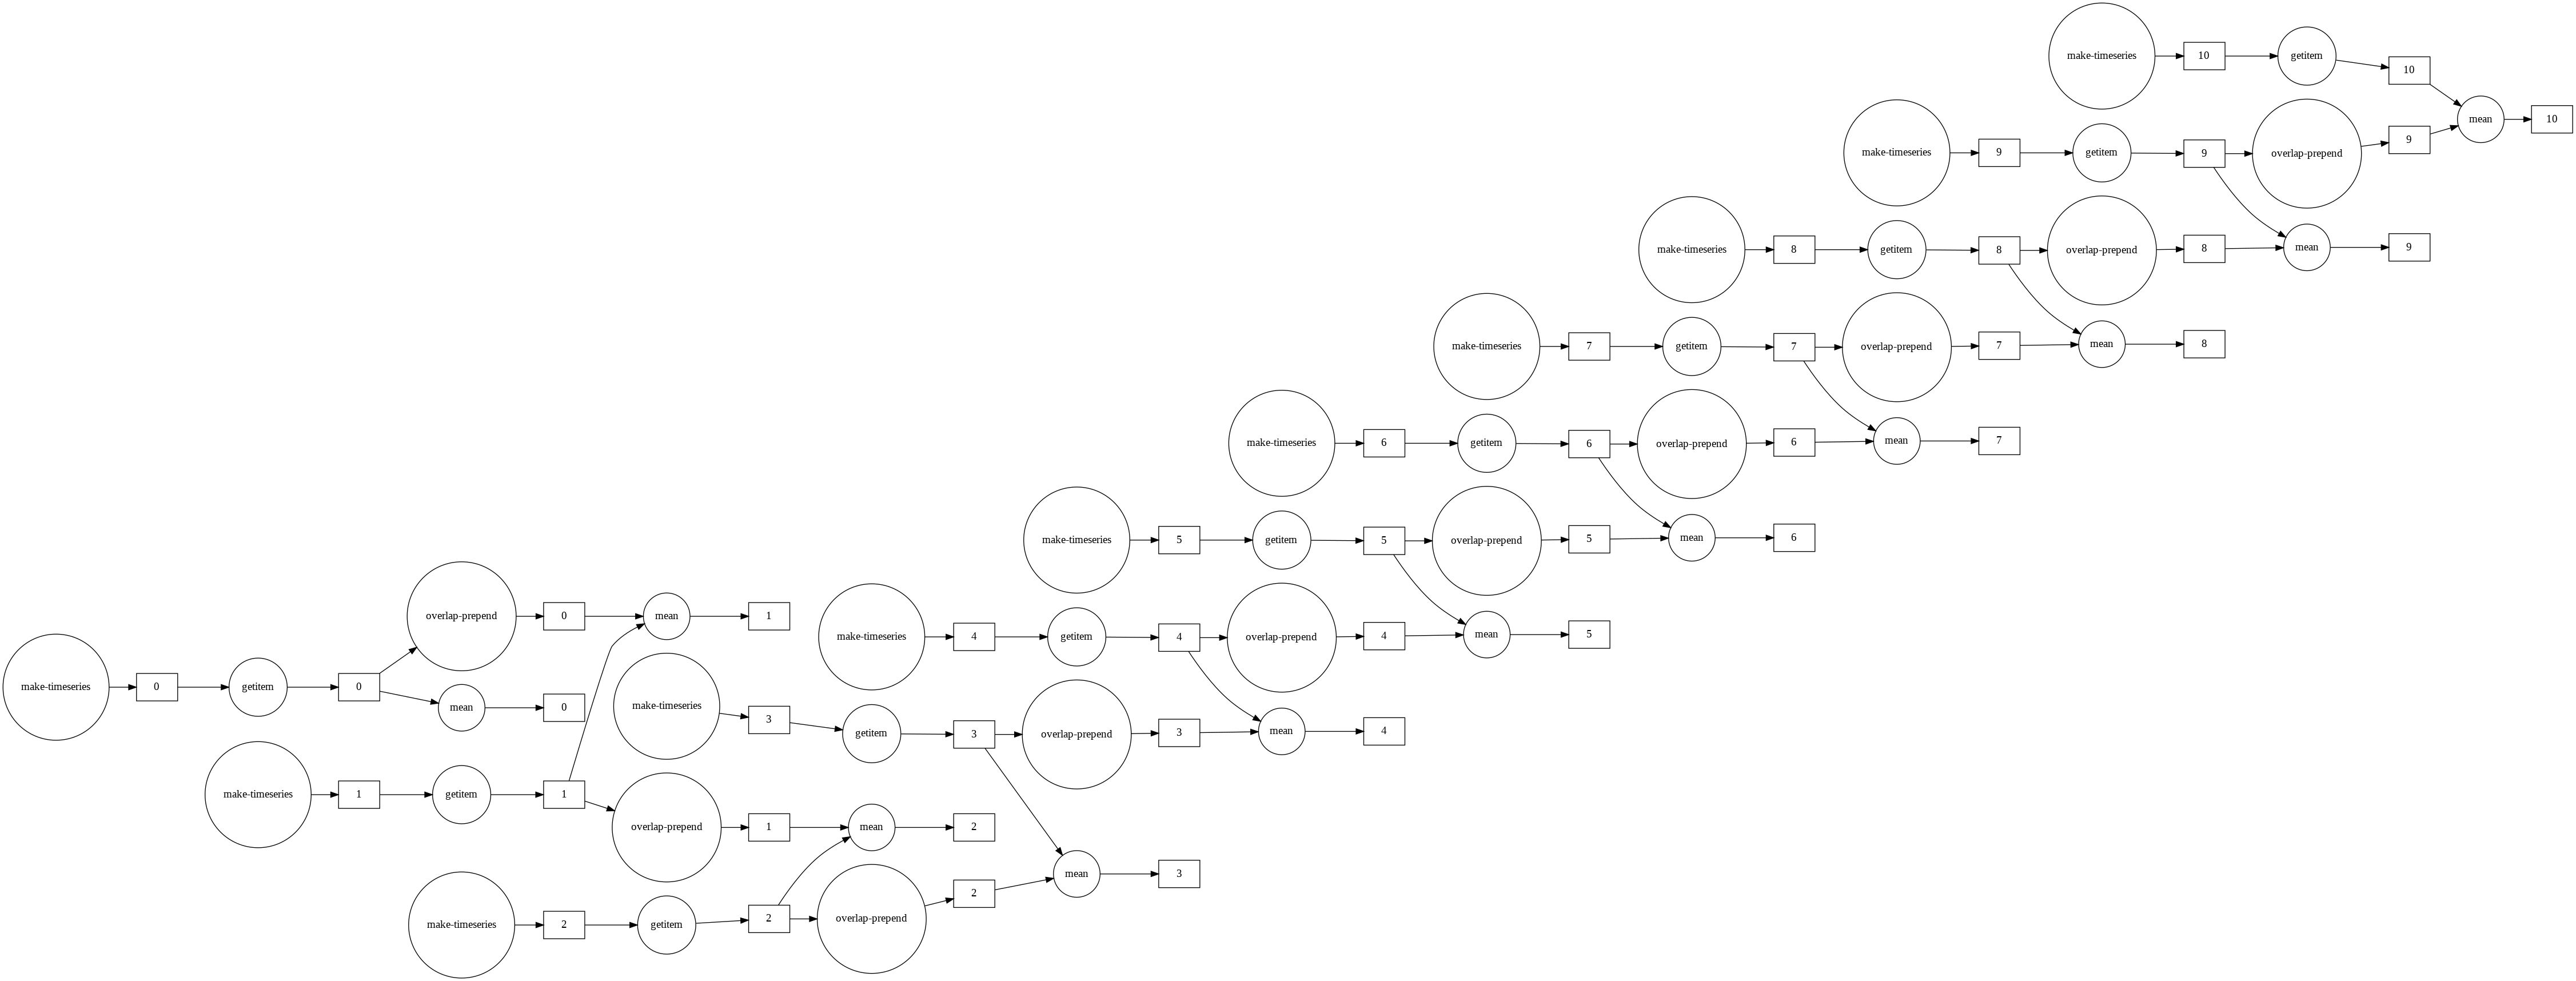

In [43]:
df_small.value.rolling(100).mean().visualize(rankdir='LR')

In [44]:
c.close()